[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/pixeltable/pixeltable/blob/master/docs/release/tutorials/working-with-openai.ipynb)&nbsp;&nbsp;
[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pixeltable/pixeltable/blob/master/docs/release/tutorials/working-with-openai.ipynb)

# Working with OpenAI in Pixeltable

Pixeltable unifies data and computation into a table interface. In the [Pixeltable Basics](https://pixeltable.github.io/pixeltable/tutorials/pixeltable-basics/) tutorial, we saw how OpenAI API calls can be incorporated into Pixeltable workflows. In this tutorial, we'll go into more depth on OpenAI integration. You'll need an OpenAI API key to run this demo.

### Prerequisites
- An OpenAI account with an API key (https://openai.com/index/openai-api/)

### Important Notes

- OpenAI usage may incur costs based on your OpenAI plan.
- Be mindful of sensitive data and consider security measures when integrating with external services.

In [1]:
%pip install -q pixeltable openai tiktoken sentence-transformers

In [22]:
from pixeltable.iterators.document import DocumentSplitter
from pixeltable.functions.huggingface import sentence_transformer
import pixeltable as pxt
import numpy as np
import urllib.request
import tiktoken

In [23]:
# Make sure we start with a clean slate
pxt.drop_table('rag_demo1.chunks', ignore_errors=True)
pxt.drop_table('rag_demo1.documents', ignore_errors=True)
pxt.drop_table('rag_demo1.queries', ignore_errors=True, force=True)
pxt.drop_table('rag_demo1.docs', ignore_errors=True)

## Creating the Table

First, we'll create a table and populate it with some sample data.

In [24]:
# Create the Pixeltable workspace
pxt.create_dir('rag_demo1', ignore_errors=True)

In [25]:
# pxt.drop_table('demo.openai', ignore_errors=True)
# t = pxt.create_table('demo.openai', {'id': pxt.IntType(), 'input': pxt.StringType()})
pxt.drop_table('rag_demo1.docs', ignore_errors=True)
docs = pxt.create_table('rag_demo1.docs', {
    'source_doc': pxt.DocumentType()
})

Created table `docs`.


In [26]:
import pixeltable as pxt
import urllib

# Local file path of the single PDF file
file_path = r"/content/data.pdf"

# Create a table to store the document
documents_t = pxt.create_table(
    'rag_demo1.documents', {'document': pxt.DocumentType()}
)

# Insert the single PDF document into the table
try:
    documents_t.insert([{'document': file_path}])
    print("Document inserted successfully.")
except pxt.exceptions.Error as e:
    print(f"Error inserting document: {e}")


Created table `documents`.
Inserting rows into `documents`: 1 rows [00:00, 101.93 rows/s]
Inserted 1 row with 0 errors.
Document inserted successfully.


In [27]:
# Create a view to split documents into chunks
chunks_t = pxt.create_view(
    'rag_demo1.chunks',
    documents_t,
    iterator=DocumentSplitter.create(
        document=documents_t.document,
        separators='token_limit', limit=300
    )
)



Inserting rows into `chunks`: 23 rows [00:00, 1552.57 rows/s]
Created view `chunks` with 23 rows, 0 exceptions.


In [31]:
@pxt.expr_udf
def e5_embed(text: str) -> np.ndarray:
    return sentence_transformer(text, model_id='intfloat/e5-large-v2')

chunks_t.add_embedding_index('text', text_embed=e5_embed)

modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/67.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/201 [00:00<?, ?B/s]

Computing cells: 100%|██████████████████████████████████████████| 23/23 [03:17<00:00,  8.58s/ cells]


In [32]:
# chunks_t['new'] =sentence_transformer(chunks_t.text, model_id='paraphrase-MiniLM-L6-v2')

pos,text,minilm_embed,new,document
0,"PROMPT OPTIMIZATION ENGINE: Overcoming \nHallucinations in LLMs through Prompt Engineering \nSarfaraz Ahmed \nDepartment of Computer Systems \nEngineering \nMehran University of Engineering \nand Technology \nJamshoro, Pakistan \nsarfarazahmedbehan2@gmail.com \nAbdul Qadir \nDepartment of Computer Systems \nEngineering \nMehran University of Engineering \nand Technology \nJamshoro, Pakistan \nabdulqadirrmagssii@gmail.com \nMuhammad Areeb \nDepartment of Computer \nSystems Engineering \nMehran University of \nEngineering and Technology \nJamshoro, Pakistan \nsyedareebali795@gmail.com \nHuzaifa Saeed \nDepartment of Computer Systems \nEngineering \nMehran University of Engineering \nand Technology \nJamshoro, Pakistan \nhuzai.exe@gmail.com \nSanam Narejo \nDepartment of Computer Systems \nEngineering \nMehran University of Engineering \nand Technology \nJamshoro, Pakistan \nSanam.narejo@faculty.muet.edu.pk \nBhawani Shankar Chowdhry \nExecutive Head, National Centre \nfor Robotics, Automation and AI \n(NCRAAI), Mehran University \nof Engineering & Technology, \nJamshoro, Pakistan \nbhawani.chowdhry@faculty.muet \n.edu.pk \n \nABSTRACT \nIn an era dominated by Generative AI, the significance of efficiently interacting with Large Language \nModels (","[-0.5824147, 0.2235151, -0.1734538, -0.44070667, -0.22663829, -0.027024034, 0.014970129, -0.16333339, -0.020586066, 0.081003994, -0.18533118, 0.16269538, 0.5308771, -0.4333089, 0.08958122, 0.0916405, 0.09296043, -0.068504, 0.16577008, -0.4405447, -0.12290316, -0.55149865, 0.057357322, -0.19765583, -0.044204928, 0.17673607, 0.2434942, 0.062247142, -0.09950496, -0.004613444, 0.13860431, -0.07189898, 0.5669384, -0.029829677, -0.13040107, 0.37277788, -0.03665312, 0.014725897, 0.08064056, -0.34140456, -0.30709147, 0.00021182536, 0.069134414, -0.27827692, 0.29075515, -0.20770958, -0.13711709, 0.08371833, -0.22300686, -0.028909668, -0.05778163, 0.025445458, 0.0026810395, -0.13394293, 0.036253255, -0.21893485, 0.22213398, 0.21834406, -0.2963248, -0.34799796, -0.12220154, -0.20477034, 0.0421481, 0.061942063, 0.2633578, 0.18239583, 0.05403911, 0.35215822, 0.36422047, 0.068113685, -0.033817053, -0.096097045, -0.54337126, -0.09916494, 0.06483145, -0.25615254, -0.28081772, -0.007862332, -0.038916625, -0.2948862, 0.08803503, -0.026646048, -0.24020806, -0.07407079, -0.122876935, -0.01791397, 0.30270442, 0.062345266, 0.446906, -0.20728374, 0.25861603, -0.28289893, -0.04319671, 0.22774184, 0.42408818, -0.015642427, 0.1881712, -0.5867055, -0.21187317, 0.18726423, ...]","[-0.5824147, 0.2235151, -0.1734538, -0.44070667, -0.22663829, -0.027024034, 0.014970129, -0.16333339, -0.020586066, 0.081003994, -0.18533118, 0.16269538, 0.5308771, -0.4333089, 0.08958122, 0.0916405, 0.09296043, -0.068504, 0.16577008, -0.4405447, -0.12290316, -0.55149865, 0.057357322, -0.19765583, -0.044204928, 0.17673607, 0.2434942, 0.062247142, -0.09950496, -0.004613444, 0.13860431, -0.07189898, 0.5669384, -0.029829677, -0.13040107, 0.37277788, -0.03665312, 0.014725897, 0.08064056, -0.34140456, -0.30709147, 0.00021182536, 0.069134414, -0.27827692, 0.29075515, -0.20770958, -0.13711709, 0.08371833, -0.22300686, -0.028909668, -0.05778163, 0.025445458, 0.0026810395, -0.13394293, 0.036253255, -0.21893485, 0.22213398, 0.21834406, -0.2963248, -0.34799796, -0.12220154, -0.20477034, 0.0421481, 0.061942063, 0.2633578, 0.18239583, 0.05403911, 0.35215822, 0.36422047, 0.068113685, -0.033817053, -0.096097045, -0.54337126, -0.09916494, 0.06483145, -0.25615254, -0.28081772, -0.007862332, -0.038916625, -0.2948862, 0.08803503, -0.026646048, -0.24020806, -0.07407079, -0.122876935, -0.01791397, 0.30270442, 0.062345266, 0.446906, -0.20728374, 0.25861603, -0.28289893, -0.04319671, 0.22774184, 0.42408818, -0.015642427, 0.1881712, -0.5867055, -0.21187317, 0.18726423, ...]",

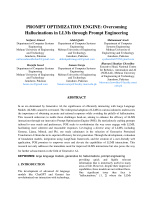

In [33]:
chunks_t.head(1)

In [34]:
query_text = "What is Chain of Thought?"

In [35]:
sim = chunks_t.text.similarity(query_text)
nvidia_eps_query = (
            chunks_t.order_by(sim, asc=False)
            .select(similarity=sim, text=chunks_t.text)
            .limit(5)
        )
print(nvidia_eps_query.collect())

   similarity                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

<h1>Above My Work

In [4]:
# text from https://en.wikipedia.org/wiki/Global_financial_crisis_in_September_2008

wikipedia_text = '''On Sunday, September 14, it was announced that Lehman Brothers would file for bankruptcy after the Federal Reserve Bank declined to participate in creating a financial support facility for Lehman Brothers.
The significance of the Lehman Brothers bankruptcy is disputed with some assigning it a pivotal role in the unfolding of subsequent events.
The principals involved, Ben Bernanke and Henry Paulson, dispute this view, citing a volume of toxic assets at Lehman which made a rescue impossible.[16][17] Immediately following the bankruptcy, JPMorgan Chase provided the broker dealer unit of Lehman Brothers with $138 billion to "settle securities transactions with customers of Lehman and its clearance parties" according to a statement made in a New York City Bankruptcy court filing.[18]
The same day, the sale of Merrill Lynch to Bank of America was announced.[19] The beginning of the week was marked by extreme instability in global stock markets, with dramatic drops in market values on Monday, September 15, and Wednesday, September 17.
On September 16, the large insurer American International Group (AIG), a significant participant in the credit default swaps markets, suffered a liquidity crisis following the downgrade of its credit rating.
The Federal Reserve, at AIG's request, and after AIG had shown that it could not find lenders willing to save it from insolvency, created a credit facility for up to US$85 billion in exchange for a 79.9% equity interest, and the right to suspend dividends to previously issued common and preferred stock.[20]'''

sample_inputs = wikipedia_text.split('\n')

In [5]:
# Insert a single sample row into the table
t.insert(id=0, input=sample_inputs[0])
t.show()

Computing cells:   0%|                                                    | 0/1 [00:00<?, ? cells/s]
Inserting rows into `openai`: 1 rows [00:00, 124.15 rows/s]
Computing cells: 100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 60.28 cells/s]
Inserted 1 row with 0 errors.


id,input
0,"On Sunday, September 14, it was announced that Lehman Brothers would file for bankruptcy after the Federal Reserve Bank declined to participate in creating a financial support facility for Lehman Brothers."


## Making OpenAI API calls

Calling OpenAI API endpoints involves constructing a message object, which we can express in Pixeltable by adding a new computed column.

In [6]:
prompt = "For the following sentence, extract all company names from the text."

msgs = [
    { "role": "system", "content": prompt },
    { "role": "user", "content": t.input }
]

t.add_column(input_msgs=msgs)

Computing cells: 100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 64.44 cells/s]
Added 1 column value with 0 errors.


UpdateStatus(num_rows=1, num_computed_values=1, num_excs=0, updated_cols=[], cols_with_excs=[])

Unlike the values of the`input` column, which users provide, the `t.input_msgs` column is computed automatically from the `t.input` column values:

In [7]:
t.show()

id,input,input_msgs
0,"On Sunday, September 14, it was announced that Lehman Brothers would file for bankruptcy after the Federal Reserve Bank declined to participate in creating a financial support facility for Lehman Brothers.","[{'role': 'system', 'content': 'For the following sentence, extract all company names from the text.'}, {'role': 'user', 'content': 'On Sunday, September 14, it was announced that Lehman Brothers would file for bankruptcy after the Federal Reserve Bank declined to participate in creating a financial support facility for Lehman Brothers.'}]"


In Pixeltable, OpenAI API calls are exposed as Pixeltable functions, which can be used to create computed columns. You'll need to enter your OpenAI API key now.

In [8]:
import os
os.environ['OPENAI_API_KEY'] = "sk-proj-lPoqX8DjLpfp56GjykkMT3BlbkFJDT8dYbKFqUuZpYp9DAhe"

Now we can run the prompt against our input data using OpenAI's `chat_completions` API.

In [9]:
from pixeltable.functions import openai

t['chat_output'] = openai.chat_completions(model='gpt-4o', messages=t.input_msgs)
t.show()

Computing cells: 100%|████████████████████████████████████████████| 1/1 [00:01<00:00,  1.77s/ cells]
Added 1 column value with 0 errors.


id,input,input_msgs,chat_output
0,"On Sunday, September 14, it was announced that Lehman Brothers would file for bankruptcy after the Federal Reserve Bank declined to participate in creating a financial support facility for Lehman Brothers.","[{'role': 'system', 'content': 'For the following sentence, extract all company names from the text.'}, {'role': 'user', 'content': 'On Sunday, September 14, it was announced that Lehman Brothers would file for bankruptcy after the Federal Reserve Bank declined to participate in creating a financial support facility for Lehman Brothers.'}]","{'id': 'chatcmpl-9ehUWCxxKSPR2yxNVccWm0tQUCvH8', 'model': 'gpt-4o-2024-05-13', 'usage': {'total_tokens': 70, 'prompt_tokens': 61, 'completion_tokens': 9}, 'object': 'chat.completion', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': '- Lehman Brothers\n- Federal Reserve Bank', 'tool_calls': None, 'function_call': None}, 'logprobs': None, 'finish_reason': 'stop'}], 'created': 1719487328, 'service_tier': None, 'system_fingerprint': 'fp_ce0793330f'}"


The output of the OpenAI API calls are generally complex JSON structures, which require some navigation to extract the response. We can express this as JSON path expressions and create another computed column:

In [10]:
t['response'] = t.chat_output.choices[0].message.content
t.show()

Computing cells: 100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 65.38 cells/s]
Added 1 column value with 0 errors.


id,input,input_msgs,chat_output,response
0,"On Sunday, September 14, it was announced that Lehman Brothers would file for bankruptcy after the Federal Reserve Bank declined to participate in creating a financial support facility for Lehman Brothers.","[{'role': 'system', 'content': 'For the following sentence, extract all company names from the text.'}, {'role': 'user', 'content': 'On Sunday, September 14, it was announced that Lehman Brothers would file for bankruptcy after the Federal Reserve Bank declined to participate in creating a financial support facility for Lehman Brothers.'}]","{'id': 'chatcmpl-9ehUWCxxKSPR2yxNVccWm0tQUCvH8', 'model': 'gpt-4o-2024-05-13', 'usage': {'total_tokens': 70, 'prompt_tokens': 61, 'completion_tokens': 9}, 'object': 'chat.completion', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': '- Lehman Brothers\n- Federal Reserve Bank', 'tool_calls': None, 'function_call': None}, 'logprobs': None, 'finish_reason': 'stop'}], 'created': 1719487328, 'service_tier': None, 'system_fingerprint': 'fp_ce0793330f'}",- Lehman Brothers\n- Federal Reserve Bank


Let's run a query to look only at the input and output:

In [11]:
t.select(t.input, t.response).show()

input,response
"On Sunday, September 14, it was announced that Lehman Brothers would file for bankruptcy after the Federal Reserve Bank declined to participate in creating a financial support facility for Lehman Brothers.",- Lehman Brothers\n- Federal Reserve Bank


Once we have defined these computed columns, much like with a spreadsheet, newly inserted `t.input` values trigger computation of all derived columns, such as `t.response`. Let's insert the rest of our data and see how this works.

In [12]:
t.insert({'id': i, 'input': sample_inputs[i]} for i in range(1, len(sample_inputs)))

Computing cells: 100%|██████████████████████████████████████████| 20/20 [00:02<00:00,  6.78 cells/s]
Inserting rows into `openai`: 5 rows [00:00, 468.12 rows/s]
Computing cells: 100%|██████████████████████████████████████████| 20/20 [00:02<00:00,  6.72 cells/s]
Inserted 5 rows with 0 errors.


UpdateStatus(num_rows=5, num_computed_values=20, num_excs=0, updated_cols=[], cols_with_excs=[])

In [13]:
t.select(t.input, t.response).show()

input,response
"On Sunday, September 14, it was announced that Lehman Brothers would file for bankruptcy after the Federal Reserve Bank declined to participate in creating a financial support facility for Lehman Brothers.",- Lehman Brothers\n- Federal Reserve Bank
The significance of the Lehman Brothers bankruptcy is disputed with some assigning it a pivotal role in the unfolding of subsequent events.,Lehman Brothers
"The principals involved, Ben Bernanke and Henry Paulson, dispute this view, citing a volume of toxic assets at Lehman which made a rescue impossible.[16][17] Immediately following the bankruptcy, JPMorgan Chase provided the broker dealer unit of Lehman Brothers with $138 billion to ""settle securities transactions with customers of Lehman and its clearance parties"" according to a statement made in a New York City Bankruptcy court filing.[18]",- Lehman Brothers\n- JPMorgan Chase
"The same day, the sale of Merrill Lynch to Bank of America was announced.[19] The beginning of the week was marked by extreme instability in global stock markets, with dramatic drops in market values on Monday, September 15, and Wednesday, September 17.","Merrill Lynch, Bank of America"
"On September 16, the large insurer American International Group (AIG), a significant participant in the credit default swaps markets, suffered a liquidity crisis following the downgrade of its credit rating.",American International Group (AIG)
"The Federal Reserve, at AIG's request, and after AIG had shown that it could not find lenders willing to save it from insolvency, created a credit facility for up to US$85 billion in exchange for a 79.9% equity interest, and the right to suspend dividends to previously issued common and preferred stock.[20]",- The Federal Reserve\n- AIG


## Adding Ground Truth Data

Now let's see how Pixeltable can be used to evaluate a model against ground truth data. We'll start by manually populating a `ground_truth` column in our table.

In [14]:
t['ground_truth'] = pxt.StringType(nullable=True)

ground_truth = [
    'Lehman Brothers',
    'Lehman Brothers',
    'JP Morgan Chase, Lehman Brothers',
    'Merill Lynch, Bank of America',
    'American International Group',
    'American International Group',
]

for i, gt in enumerate(ground_truth):
    t.update({'ground_truth': gt}, where=(t.id == i))

Computing cells: 100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 164.99 cells/s]
Added 6 column values with 0 errors.
Inserting rows into `openai`: 1 rows [00:00, 186.26 rows/s]
Inserting rows into `openai`: 1 rows [00:00, 188.63 rows/s]
Inserting rows into `openai`: 1 rows [00:00, 233.87 rows/s]
Inserting rows into `openai`: 1 rows [00:00, 226.94 rows/s]
Inserting rows into `openai`: 1 rows [00:00, 178.44 rows/s]
Inserting rows into `openai`: 1 rows [00:00, 249.29 rows/s]


And this is what we have so far:

In [15]:
t.select(t.input, t.response, t.ground_truth).show()

input,response,ground_truth
"On Sunday, September 14, it was announced that Lehman Brothers would file for bankruptcy after the Federal Reserve Bank declined to participate in creating a financial support facility for Lehman Brothers.",- Lehman Brothers\n- Federal Reserve Bank,Lehman Brothers
The significance of the Lehman Brothers bankruptcy is disputed with some assigning it a pivotal role in the unfolding of subsequent events.,Lehman Brothers,Lehman Brothers
"The principals involved, Ben Bernanke and Henry Paulson, dispute this view, citing a volume of toxic assets at Lehman which made a rescue impossible.[16][17] Immediately following the bankruptcy, JPMorgan Chase provided the broker dealer unit of Lehman Brothers with $138 billion to ""settle securities transactions with customers of Lehman and its clearance parties"" according to a statement made in a New York City Bankruptcy court filing.[18]",- Lehman Brothers\n- JPMorgan Chase,"JP Morgan Chase, Lehman Brothers"
"The same day, the sale of Merrill Lynch to Bank of America was announced.[19] The beginning of the week was marked by extreme instability in global stock markets, with dramatic drops in market values on Monday, September 15, and Wednesday, September 17.","Merrill Lynch, Bank of America","Merill Lynch, Bank of America"
"On September 16, the large insurer American International Group (AIG), a significant participant in the credit default swaps markets, suffered a liquidity crisis following the downgrade of its credit rating.",American International Group (AIG),American International Group
"The Federal Reserve, at AIG's request, and after AIG had shown that it could not find lenders willing to save it from insolvency, created a credit facility for up to US$85 billion in exchange for a 79.9% equity interest, and the right to suspend dividends to previously issued common and preferred stock.[20]",- The Federal Reserve\n- AIG,American International Group


## Evaluation

Now that we have some ground truth available, we can carry out basic evaluations of the GPT outputs, in this case by asking ChatGPT to decide whether the two are equivalent.

To start with, we'll create an evaluation prompt. In this case, the prompt requires some bespoke string substitution, so it's easiest to do using a UDF. (See the [Pixeltable Basics](https://pixeltable.github.io/pixeltable/tutorials/pixeltable-basics/) tutorial and the [UDFs in Pixeltable](https://pixeltable.github.io/pixeltable/howto/udfs-in-pixeltable/) guide for more details on UDFs.)

In [16]:
system_prompt = '''
Compare the following listA and listB of entities, and check if they contain the same entities.
Return a JSON object with the following format:
{"reasoning": explaining your reasoning, "decision": 1 if the lists matched, 0 otherwise}
'''

@pxt.udf
def eval_prompt(listA: str, listB: str) -> list[dict]:
    return [
        {'role': 'system', 'content': system_prompt},
        {'role': 'user', 'content': f'listA: "{listA}" \n listB: "{listB}"'}
    ]

t['eval_prompt'] = eval_prompt(t.response, t.ground_truth)

Computing cells: 100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 135.02 cells/s]
Added 6 column values with 0 errors.


In [17]:
t.select(t.eval_prompt).show()

eval_prompt
"[{'role': 'system', 'content': ' Compare the following listA and listB of entities, and check if they contain the same entities. Return a JSON object with the following format: {""reasoning"": explaining your reasoning, ""decision"": 1 if the lists matched, 0 otherwise} '}, {'role': 'user', 'content': 'listA: ""Lehman Brothers"" listB: ""Lehman Brothers""'}]"
"[{'role': 'system', 'content': ' Compare the following listA and listB of entities, and check if they contain the same entities. Return a JSON object with the following format: {""reasoning"": explaining your reasoning, ""decision"": 1 if the lists matched, 0 otherwise} '}, {'role': 'user', 'content': 'listA: ""Merrill Lynch, Bank of America"" listB: ""Merill Lynch, Bank of America""'}]"
"[{'role': 'system', 'content': ' Compare the following listA and listB of entities, and check if they contain the same entities. Return a JSON object with the following format: {""reasoning"": explaining your reasoning, ""decision"": 1 if the lists matched, 0 otherwise} '}, {'role': 'user', 'content': 'listA: ""- The Federal Reserve - AIG"" listB: ""American International Group""'}]"
"[{'role': 'system', 'content': ' Compare the following listA and listB of entities, and check if they contain the same entities. Return a JSON object with the following format: {""reasoning"": explaining your reasoning, ""decision"": 1 if the lists matched, 0 otherwise} '}, {'role': 'user', 'content': 'listA: ""- Lehman Brothers - Federal Reserve Bank"" listB: ""Lehman Brothers""'}]"
"[{'role': 'system', 'content': ' Compare the following listA and listB of entities, and check if they contain the same entities. Return a JSON object with the following format: {""reasoning"": explaining your reasoning, ""decision"": 1 if the lists matched, 0 otherwise} '}, {'role': 'user', 'content': 'listA: ""- Lehman Brothers - JPMorgan Chase"" listB: ""JP Morgan Chase, Lehman Brothers""'}]"
"[{'role': 'system', 'content': ' Compare the following listA and listB of entities, and check if they contain the same entities. Return a JSON object with the following format: {""reasoning"": explaining your reasoning, ""decision"": 1 if the lists matched, 0 otherwise} '}, {'role': 'user', 'content': 'listA: ""American International Group (AIG)"" listB: ""American International Group""'}]"


The actual evaluation happens in another computed column. We can use OpenAI's handy `response_format` parameter to enforce that the output is properly formed JSON.

In [18]:
t['eval'] = openai.chat_completions(model='gpt-3.5-turbo', messages=t.eval_prompt, response_format={'type': 'json_object'})
t['eval_output'] = t.eval.choices[0].message.content

Computing cells: 100%|████████████████████████████████████████████| 6/6 [00:08<00:00,  1.42s/ cells]
Added 6 column values with 0 errors.
Computing cells: 100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 184.61 cells/s]
Added 6 column values with 0 errors.


Let's take a look:

In [19]:
t.select(t.response, t.ground_truth, t.eval_output).show()

response,ground_truth,eval_output
Lehman Brothers,Lehman Brothers,"{""reasoning"": ""Both listA and listB contain the same entity 'Lehman Brothers'."", ""decision"": 1}"
"Merrill Lynch, Bank of America","Merill Lynch, Bank of America","{""reasoning"": ""The two lists differ in the spelling of 'Merrill Lynch'. The first spelling in listA is 'Merrill Lynch' while the one in listB is 'Merill Lynch'. This suggests a typographical error in listB. The rest of the entities 'Bank of America' are the same in both lists."", ""decision"": 0}"
- Lehman Brothers\n- Federal Reserve Bank,Lehman Brothers,"{\n ""reasoning"": ""ListB contains only one entity, 'Lehman Brothers', which is also present in ListA. The other entity in ListA, 'Federal Reserve Bank', is not in ListB."",\n ""decision"": 0\n}"
- Lehman Brothers\n- JPMorgan Chase,"JP Morgan Chase, Lehman Brothers","{\n ""reasoning"": ""The entities in listA are 'Lehman Brothers' and 'JPMorgan Chase', while the entities in listB are 'JP Morgan Chase' and 'Lehman Brothers'. Although there are some similarities between the two lists, the entities are not exactly the same due to the slight difference in naming."",\n ""decision"": 0\n}"
American International Group (AIG),American International Group,"{""reasoning"": ""The entities in listA and listB are variations of the same organization, with the only difference being the inclusion of the abbreviation 'AIG' in listA. Thus, the entities are considered to be the same."", ""decision"": 1}"
- The Federal Reserve\n- AIG,American International Group,"{""reasoning"": ""ListA contains 'AIG' as an abbreviation, while listB has the full name 'American International Group'. Therefore, they refer to the same entity."", ""decision"": 1}"


Finally, it's time to pull the `decision` out of the JSON structs returned by OpenAI. There's just one complication: the `chat_completions` responses are strings, not JSON structs. We can resolve this with Pixeltable's handy `apply` method, which turns any Python function into a Pixeltable function. In this case, we'll apply the Python function `json.loads` to parse the string into a JSON struct.

In [20]:
import json

t['eval_decision'] = t.eval_output.apply(json.loads).decision

Computing cells: 100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 180.38 cells/s]
Added 6 column values with 0 errors.


In [21]:
t.select(t.response, t.ground_truth, t.eval_output, t.eval_decision).show()

response,ground_truth,eval_output,eval_decision
- Lehman Brothers\n- Federal Reserve Bank,Lehman Brothers,"{\n ""reasoning"": ""ListB contains only one entity, 'Lehman Brothers', which is also present in ListA. The other entity in ListA, 'Federal Reserve Bank', is not in ListB."",\n ""decision"": 0\n}",0
American International Group (AIG),American International Group,"{""reasoning"": ""The entities in listA and listB are variations of the same organization, with the only difference being the inclusion of the abbreviation 'AIG' in listA. Thus, the entities are considered to be the same."", ""decision"": 1}",1
- The Federal Reserve\n- AIG,American International Group,"{""reasoning"": ""ListA contains 'AIG' as an abbreviation, while listB has the full name 'American International Group'. Therefore, they refer to the same entity."", ""decision"": 1}",1
Lehman Brothers,Lehman Brothers,"{""reasoning"": ""Both listA and listB contain the same entity 'Lehman Brothers'."", ""decision"": 1}",1
"Merrill Lynch, Bank of America","Merill Lynch, Bank of America","{""reasoning"": ""The two lists differ in the spelling of 'Merrill Lynch'. The first spelling in listA is 'Merrill Lynch' while the one in listB is 'Merill Lynch'. This suggests a typographical error in listB. The rest of the entities 'Bank of America' are the same in both lists."", ""decision"": 0}",0
- Lehman Brothers\n- JPMorgan Chase,"JP Morgan Chase, Lehman Brothers","{\n ""reasoning"": ""The entities in listA are 'Lehman Brothers' and 'JPMorgan Chase', while the entities in listB are 'JP Morgan Chase' and 'Lehman Brothers'. Although there are some similarities between the two lists, the entities are not exactly the same due to the slight difference in naming."",\n ""decision"": 0\n}",0
